In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import sklearn
from sklearn.feature_selection import SelectKBest, chi2, f_regression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import scikitplot as skplt
import xgboost as xgb
from scipy.stats import uniform, randint
from sklearn.model_selection import StratifiedKFold
from logitreg.logitreg import charts as ch, iv, lreg
import scorecardpy
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import validation_curve, learning_curve
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve, auc, classification_report
from mdl_evaluation_plots import *
import statsmodels.api as sm



%matplotlib inline

In [3]:
def round_sig(x, N=2):
    """
    round to N significant digits
    :param x: input
    :param N: # of digits
    :return:
    """

    if np.floor(np.log10(abs(x))) == np.inf:
        # -1 for invalid zero division.
        return -1

    return 0 if x == 0 else round(x, N - int(np.floor(np.log10(abs(x)))))

In [2]:
import pickle
df = pickle.load( open( "data_cleaned.pkl", "rb" ) )
display(df.head())
display(df.shape)

,close_bal,wala,issuer,init_rate,mba_prev,mba_prev2,mba_prev6,ltv,cltv,fico_bucket,geo,cd_servicer,FEDFUNDS,factor_month,close_month,month_mod,occ_bucket_investor,purp_bucket_Cash Out,purp_bucket_Refi,doc_type_BankSt,doc_type_Foreign,doc_type_Full,doc_type_Investor,cd_mstr_servicer_Nationstar,cd_mstr_servicer_SPS,cd_mstr_servicer_Wells Fargo,covid_flag_Y,is_prepay
0,179393.36,10,0.032008,0.00,0.029148,0.029996,0.022196,27.69,25.444079,4.0,0.030373,0.027853,0.41,11,7,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,272195.79,34,0.024720,5.99,0.029148,0.029996,0.022196,75.00,61.521906,2.0,0.030373,0.027853,0.06,5,1,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
2,323407.43,19,0.020420,5.25,0.029148,0.029996,0.031888,65.00,48.506555,4.0,0.031530,0.027853,2.13,8,2,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,216414.00,21,0.024720,6.55,0.029148,0.029996,0.031888,57.60,51.790911,3.0,0.024654,0.027853,2.04,9,4,0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
4,245865.99,15,0.022184,6.75,0.029148,0.029996,0.031888,59.52,54.422491,3.0,0.030373,0.027853,1.55,12,4,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


(823408, 28)

In [9]:
import joblib
df_full = joblib.load('prepay_data.pkl')

In [3]:
y_var = 'is_prepay'
X = df.drop(y_var, axis = 1)
y = df[y_var]

In [4]:
df[y_var].sum()/len(df)

0.028731807317878864

In [5]:
# split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((551683, 27), (271725, 27), (551683,), (271725,))

### Start with core attributes and LR

In [7]:
doc_Type = [i for i in X_train.columns if 'doc' in i]
lr_doc = LogisticRegression(class_weight='balanced')
lr_doc.fit(X_train[doc_Type], y_train)
print('lr_doc: ',  lr_doc.score(X_test[doc_Type], y_test))

lr_fico = LogisticRegression(class_weight='balanced')
lr_fico.fit(np.reshape(X_train['fico_bucket'].values,(-1,1)), y_train)
print('lr_fico: ',  lr_fico.score(np.reshape(X_test['fico_bucket'].values,(-1,1)), y_test))

lr_wala = LogisticRegression(class_weight='balanced')
lr_wala.fit(np.reshape(X_train['wala'].values,(-1,1)), y_train)
print('lr_wala: ',  lr_wala.score(np.reshape(X_test['wala'].values,(-1,1)), y_test))

lr_ltv = LogisticRegression(class_weight='balanced')
lr_ltv.fit(np.reshape(X_train['ltv'].values,(-1,1)), y_train)
print('lr_ltv: ',  lr_ltv.score(np.reshape(X_test['ltv'].values,(-1,1)), y_test))

lr_doc:  0.5242027785444843
lr_fico:  0.42545956389732265
lr_wala:  0.6543895482565093
lr_ltv:  0.4973484221179501


#### Document type

In [30]:
df[doc_Type]

,doc_type_BankSt,doc_type_Foreign,doc_type_Full,doc_type_Investor
0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0
...,...,...,...,...
823403,1.0,0.0,0.0,0.0
823404,0.0,0.0,0.0,1.0
823405,0.0,0.0,1.0,0.0
823406,0.0,0.0,0.0,1.0


In [15]:
lr_doc = sm.Logit(y_train.values.reshape(-1,1), X_train[doc_Type])
result_doc=lr_doc.fit()
result_doc.params

Optimization terminated successfully.
         Current function value: 0.191169
         Iterations 8


doc_type_BankSt     -3.621785
doc_type_Foreign    -4.404685
doc_type_Full       -3.310960
doc_type_Investor   -3.950918
dtype: float64

In [16]:
for i,v in result_doc.params.items():
    print(i, 1/(1 + np.exp(-v)))

doc_type_BankSt 0.026038777415470126
doc_type_Foreign 0.012072434607645692
doc_type_Full 0.03519709390800548
doc_type_Investor 0.018873952471062758


#### wala

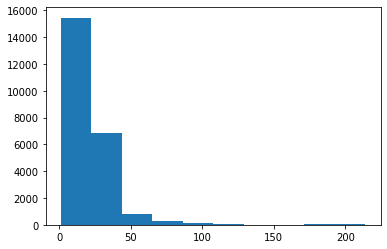

In [53]:
plt.hist(df['wala'].loc[df[y_var] == 1].dropna())
plt.show()

In [41]:
lr_wala = sm.Logit(df[y_var], df['wala'])
result_wala=lr_wala.fit()
result_wala.params

Optimization terminated successfully.
         Current function value: 0.204230
         Iterations 8


wala   -0.200964
dtype: float64

#### LTV

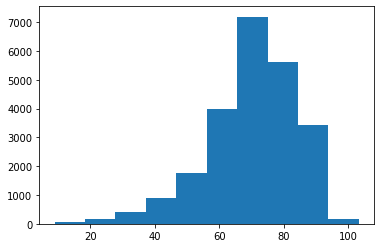

In [50]:
plt.hist(df['ltv'].loc[df[y_var] == 1].dropna())
plt.show()

In [35]:
lr_ltv = sm.Logit(y.values.reshape(-1,1), X['ltv'].values.reshape(-1,1))
result_ltv=lr_ltv.fit()
result_ltv.params

Optimization terminated successfully.
         Current function value: 0.141921
         Iterations 7


array([-0.0513596])

#### fico

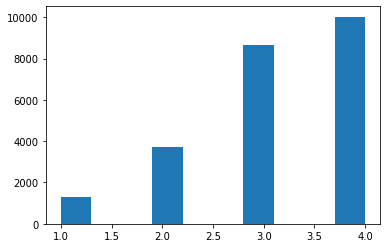

In [51]:
plt.hist(df['fico_bucket'].loc[df[y_var] == 1].dropna())
plt.show()

In [19]:
for i in range(1,5):
    print(len(df[(df['fico_bucket'] == i) & (df[y_var]) == 1]) / len(df[(df['fico_bucket'] == i)]))

0.03644883414237212
0.029104883100111032
0.0274969994301305
0.028920625488572806


In [18]:
for i in range(1,5):
    print(len(df[(df['fico_bucket'] == i) & (df[y_var] == 0)]) / len(df[(df['fico_bucket'] == i)]))

0.9635511658576279
0.9708951168998889
0.9725030005698695
0.9710793745114272


In [ ]:
lr_fico = sm.Logit(df[y_var], df['fico_bucket'])
result_fico=lr_fico.fit()
result_fico.params

In [32]:
df[y_var].sum()/len(df)

0.028731807317878864

In [59]:
for i in range(1,5):
    print(len(df[(df['fico_bucket'] == i) & (df[y_var] == 1)]) / len(df[df[y_var] == 1]))


0.05490743089018514
0.15622622368754754
0.3650773522698453
0.423788993152422


In [60]:
for i in range(1,5):
    print(len(df[(df['fico_bucket'] == i) & (df[y_var] == 0)]) / len(df[df[y_var] == 0]))


0.04293841825570491
0.15416442638324476
0.38195686151922476
0.4209402938418256


In [64]:
for i in doc_Type:
    print(i,df[i].loc[df[y_var] == 1].sum() / len(df[df[y_var] == 1]))

doc_type_BankSt 0.24368078451263844
doc_type_Foreign 0.00033815199932369603
doc_type_Full 0.5844111928311776
doc_type_Investor 0.09645785780708428


In [63]:
for i in doc_Type:
    print(i,df[i].loc[df[y_var] == 0].sum() / len(df[df[y_var] == 0]))

doc_type_BankSt 0.2686239449828071
doc_type_Foreign 0.0008990309471709909
doc_type_Full 0.4770665833072835
doc_type_Investor 0.14881150359487338


In [42]:
from sklearn.preprocessing import OneHotEncoder
onehotenc = OneHotEncoder()
onehotencoded_fico = pd.DataFrame(onehotenc.fit_transform(np.reshape(df['fico_bucket'].values,(-1,1))).toarray())
onehotencoded_fico.columns = onehotenc.get_feature_names(['fico_bucket'])
onehotencoded_fico

,fico_bucket_1.0,fico_bucket_2.0,fico_bucket_3.0,fico_bucket_4.0
0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,1.0
3,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0
...,...,...,...,...
823403,0.0,1.0,0.0,0.0
823404,0.0,1.0,0.0,0.0
823405,0.0,0.0,1.0,0.0
823406,0.0,0.0,0.0,1.0


In [43]:
df['fico_bucket']

0         4.0
1         2.0
2         4.0
3         3.0
4         3.0
         ... 
823403    2.0
823404    2.0
823405    3.0
823406    4.0
823407    4.0
Name: fico_bucket, Length: 823408, dtype: float64

In [32]:
df[y_var].sum()/len(df)

0.028731807317878864

In [68]:
lr_fico_ohe_2 = sm.Logit(df[y_var], onehotencoded_fico[['fico_bucket_1.0', 'fico_bucket_2.0', 'fico_bucket_3.0']])
result_fico_ohe_2=lr_fico_ohe_2.fit()
result_fico_ohe_2.params

Optimization terminated successfully.
         Current function value: 0.366941
         Iterations 8


fico_bucket_1.0   -3.274716
fico_bucket_2.0   -3.507312
fico_bucket_3.0   -3.565796
dtype: float64

In [71]:
for i,v in result_fico_ohe_2.params.items():
    print(i, 1/(1 + np.exp(-v)))

fico_bucket_1.0 0.0364488341423722
fico_bucket_2.0 0.029104883100111386
fico_bucket_3.0 0.027496999430130446


In [69]:
lr_fico = LogisticRegression(class_weight='balanced')
lr_fico.fit(onehotencoded_fico[['fico_bucket_1.0', 'fico_bucket_2.0', 'fico_bucket_3.0']], df[y_var])
lr_fico.coef_[0]

array([ 0.23911608,  0.00653956, -0.05194353])

In [33]:
for i in zip([i for i in X_train.columns if 'doc' in i],[np.exp(x)/(1 + np.exp(x)) for x in lr_doc.coef_[0]]):
    print(i)

('doc_type_BankSt', 0.5576646569311879)
('doc_type_Foreign', 0.36726522102924114)
('doc_type_Full', 0.6323968630580644)
('doc_type_Investor', 0.4756588324003306)


In [73]:
lrr = LogisticRegression(class_weight='balanced')
lrr.fit(onehotencoded_fico, y_train)
for i in zip(onehotencoded_fico.columns, [1/(1 + np.exp(-x)) for x in lrr.coef_[0]]):
    print(i)

('fico_bucket_1.0', 0.5538201244209376)
('fico_bucket_2.0', 0.4936835881158554)
('fico_bucket_3.0', 0.47579499074722265)
('fico_bucket_4.0', 0.48866516431144164)


In [75]:
onehotencoded_fico.head()

,fico_bucket_1.0,fico_bucket_2.0,fico_bucket_3.0,fico_bucket_4.0
0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0


In [74]:
onehotencoded_fico.columns

Index(['fico_bucket_1.0', 'fico_bucket_2.0', 'fico_bucket_3.0', 'fico_bucket_4.0'], dtype='object')

In [77]:
logit_model=sm.Logit(y_train.values.reshape(-1,1),onehotencoded_fico)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.130549
         Iterations 8
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: y                AIC:              144051.8449
Date:               2021-11-01 00:35 BIC:              144096.7278
No. Observations:   551683           Log-Likelihood:   -72022.    
Df Model:           3                LL-Null:          -72057.    
Df Residuals:       551679           LLR p-value:      4.2390e-15 
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     8.0000                                        
------------------------------------------------------------------
                  Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
fico_bucket_1.0  -3.2527   0.0342  -95.1072 0.0000 -3.3197 -3.1857
fico_bucket_2.0  -3.4941   0.0203 -172.4214 0.0000 -3

In [89]:
for i,v in result.params.items():
    print(i, 1/(1 + np.exp(-v)))

fico_bucket_1.0 0.03722958242495372
fico_bucket_2.0 0.02947984349481278
fico_bucket_3.0 0.027498052478576784
fico_bucket_4.0 0.02891067106521142


In [93]:
logit_model_doc=sm.Logit(y_train.values.reshape(-1,1),X_train[doc_Type])
result_doc=logit_model_doc.fit()
print(result_doc.summary2())

Optimization terminated successfully.
         Current function value: 0.191169
         Iterations 8
                          Results: Logit
Model:               Logit            Pseudo R-squared: -0.464     
Dependent Variable:  y                AIC:              210937.6521
Date:                2021-11-01 00:42 BIC:              210982.5351
No. Observations:    551683           Log-Likelihood:   -1.0546e+05
Df Model:            3                LL-Null:          -72057.    
Df Residuals:        551679           LLR p-value:      1.0000     
Converged:           1.0000           Scale:            1.0000     
No. Iterations:      8.0000                                        
-------------------------------------------------------------------
                   Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
-------------------------------------------------------------------
doc_type_BankSt   -3.6218   0.0163 -221.7519 0.0000 -3.6538 -3.5898
doc_type_Foreign  -4.4047   0.4107  -10.7

In [94]:
for i,v in result_doc.params.items():
    print(i, 1/(1 + np.exp(-v)))

doc_type_BankSt 0.026038777415470126
doc_type_Foreign 0.012072434607645692
doc_type_Full 0.03519709390800548
doc_type_Investor 0.018873952471062758


In [37]:
[1/(1 + np.exp(-x)) for x in lr_wala.coef_[0]]

[0.5002007788745044]

In [12]:
onehotencoded_fico.columns

RangeIndex(start=0, stop=4, step=1)

In [26]:
X_train['fico_bucket'].unique()

array([4., 2., 3., 1.])

In [25]:
onehotencoded_fico.columns

Int64Index([1, 2, 3], dtype='int64')

In [13]:
lr_wala.coef_[0]

array([0.00080312])

doc_type


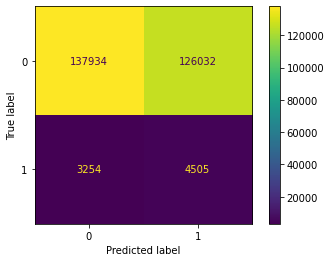

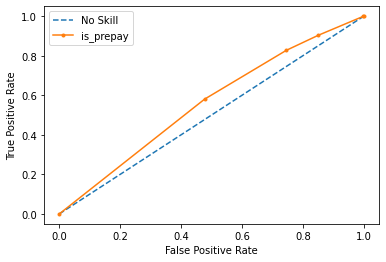

is_prepay AUC score:  0.5604482763994519

fico_bucket


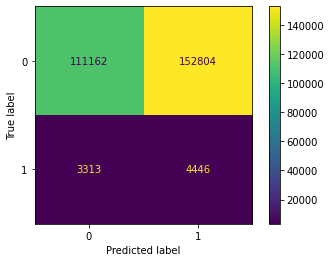

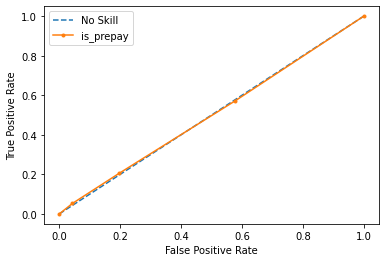

is_prepay AUC score:  0.5009496864994496

wala


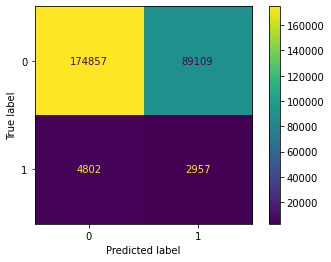

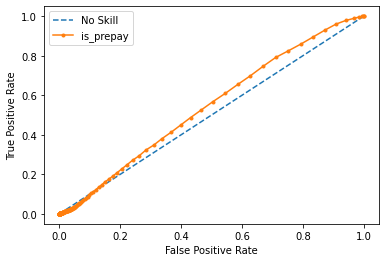

is_prepay AUC score:  0.5435679184282031

ltv


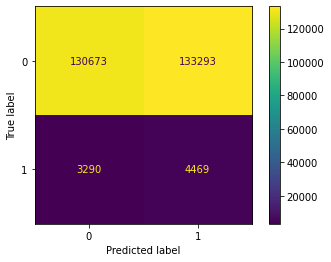

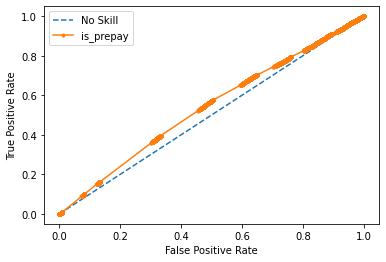

is_prepay AUC score:  0.5391081998508915



In [46]:
orig_features = [lr_doc,lr_fico, lr_wala,lr_ltv]
orig_names = ['doc_type', 'fico_bucket', 'wala', 'ltv']
for i in zip(orig_features, orig_names):
    
    if i[1] == 'doc_type':
        print(i[1])
        plot_confusion_matrix(i[0], X_test[doc_Type], y_test)
        plt.show()
        plot_roc(i[0], X_test[doc_Type], y_test, y_var)
        plt.show()
        print()
    else:
        print(i[1])
        plot_confusion_matrix(i[0], np.reshape(X_test[i[1]].values,(-1,1)), y_test)
        plt.show()
        plot_roc(i[0], np.reshape(X_test[i[1]].values,(-1,1)), y_test,y_var)
        plt.show()
        print()

In [47]:
# Get columns
orig_names.extend(doc_Type)
orig_names.remove('doc_type')
orig_names

['fico_bucket',
 'wala',
 'ltv',
 'doc_type_BankSt',
 'doc_type_Foreign',
 'doc_type_Full',
 'doc_type_Investor']

In [48]:
lr_orig = LogisticRegression(class_weight='balanced')
lr_orig.fit(X_train[orig_names], y_train)
lr_orig.score(X_test[orig_names], y_test)

0.5150317416505659

In [51]:
for i in zip(orig_names,lr_orig.coef_[0]):
    print(i)

('fico_bucket', -0.028274300455313962)
('wala', 0.003890825414018524)
('ltv', 0.005207895098245668)
('doc_type_BankSt', 0.2804928218547337)
('doc_type_Foreign', -0.04580878748645193)
('doc_type_Full', 0.5995257922792044)
('doc_type_Investor', -0.0055581543143855775)


In [23]:
X_train.fico_bucket.unique()

array([3., 4., 2., 1.])

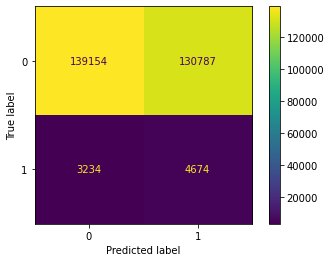

In [11]:
plot_confusion_matrix(lr_orig, X_test[orig_names], y_test)

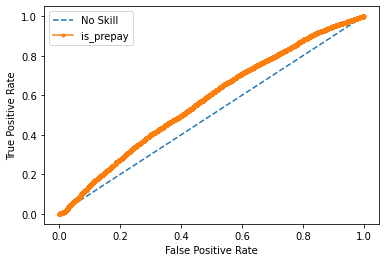

is_prepay AUC score:  0.5741520346311761


In [12]:
plot_roc(lr_orig, X_test[orig_names], y_test, y_var)

In [13]:
rf_balanced = RandomForestClassifier(class_weight='balanced')
rf_balanced.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced')

In [14]:
rf_balanced.score(X_test, y_test)

0.971488110448481

In [15]:
y_pred = rf_balanced.predict(X_test)
sklearn.metrics.classification_report(y_test, y_pred)

'              precision    recall  f1-score   support\n\n           0       0.97      1.00      0.99    269941\n           1       0.40      0.00      0.01      7908\n\n    accuracy                           0.97    277849\n   macro avg       0.69      0.50      0.50    277849\nweighted avg       0.96      0.97      0.96    277849\n'

In [16]:
print(sklearn.metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99    269941
           1       0.40      0.00      0.01      7908

    accuracy                           0.97    277849
   macro avg       0.69      0.50      0.50    277849
weighted avg       0.96      0.97      0.96    277849



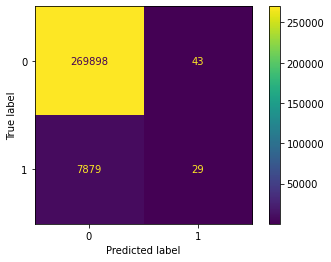

In [18]:
plot_confusion_matrix(rf_balanced, X_test, y_test)

In [21]:
importance = [round_sig(i) for i in rf_balanced.feature_importances_]
feature_importance = list(zip(X_train.columns,importance))
sorted(feature_importance, key = lambda x: x[1])

[('month_mod', 2.31e-05),
 ('cd_mstr_servicer_SPS', 6.67e-05),
 ('doc_type_Foreign', 0.00013),
 ('covid_flag_Y', 0.000168),
 ('cd_mstr_servicer_Wells Fargo', 0.00104),
 ('cd_mstr_servicer_Nationstar', 0.00173),
 ('doc_type_Investor', 0.00426),
 ('doc_type_BankSt', 0.00534),
 ('mba_prev', 0.00701),
 ('doc_type_Full', 0.00982),
 ('mba_prev2', 0.0102),
 ('purp_bucket_Refi', 0.011),
 ('occ_bucket_investor', 0.0117),
 ('mba_prev6', 0.0143),
 ('purp_bucket_Cash Out', 0.0161),
 ('cd_servicer', 0.0296),
 ('fico_bucket', 0.0354),
 ('geo', 0.0468),
 ('issuer', 0.0557),
 ('close_month', 0.059),
 ('factor_month', 0.0792),
 ('FEDFUNDS', 0.08),
 ('ltv', 0.105),
 ('init_rate', 0.117),
 ('wala', 0.135),
 ('close_bal', 0.164)]